**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Chargement des données](#toc1_1_)    
  - [Préparation des données](#toc1_2_)    
  - [Vectorisation](#toc1_3_)    
  - [LDA](#toc1_4_)    
- [Score Jaccard](#toc2_)    
- [Classification OneVsRest](#toc3_)    
  - [Régression logistique](#toc3_1_)    
  - [Nombre de tags prédits](#toc3_2_)    
- [Traitements communs](#toc4_)    
  - [Pré-traitement](#toc4_1_)    
  - [Évaluation : pipeline](#toc4_2_)    
  - [Test avec CountVectorizer](#toc4_3_)    
- [Approche *word embedding*](#toc5_)    
  - [Word 2 Vec](#toc5_1_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc6_)    
- [🚧 prepare inference function](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
import os
import logging
import time

# DS
import numpy as np
import pandas as pd
import dill as pickle

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from gensim.models import Word2Vec
import tensorflow_hub as hub

# home made functions from the src folder
from src.scrap_and_clean import init_data
from src.models import eval_lda_n_topics
from src.models import get_topics
from src.models import lr_predict_tags
from src.models import score_plot_model
from src.models import select_split_data

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

2024-05-31 12:47:09.654559: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 12:47:09.655286: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 12:47:09.669317: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 12:47:09.767712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 12:47:11.185949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## <a id='toc1_1_'></a>[Chargement des données](#toc0_)

In [2]:
df_pp = init_data()

INFO:root:✅ Preprocessed data loaded


In [3]:
print(f"DF shape: {df_pp.shape}")
display(df_pp.head())

DF shape: (49975, 10)


,doc_bow,tags,score,answers,views,date,title_bow,title,body_bow,body
0,itms-91053 missing api declaration privacy sud...,ios app-store plist,24,7,3092,2024-03-14 22:55:18,itms-91053 missing api declaration privacy,ITMS-91053: Missing API declaration - Privacy,suddent successful build apple,<p>Why am I all of a suddent getting this on s...
1,builtin sorted slower list containing descendi...,python algorithm performance sorting time-comp...,28,2,2699,2024-03-05 15:21:50,builtin sorted slower list containing descendi...,Why is builtin sorted() slower for a list cont...,sorted four similar list list consistently tak...,<p>I sorted four similar lists. List <code>d</...
2,std :shared_mutex :unlock_shared block though ...,c++ windows multithreading stl,26,5,1388,2024-03-01 23:09:59,std :shared_mutex :unlock_shared block though ...,std::shared_mutex::unlock_shared() blocks even...,team encountered deadlock suspect bug windows ...,<p>My team has encountered a deadlock that I s...
3,rules nullptr init unique_ptr c++ compiles msv...,c++ visual-c++ language-lawyer unique-ptr c++23,15,1,490,2024-02-22 11:29:42,rules nullptr init unique_ptr c++,Did the rules for nullptr init of unique_ptr c...,compiles msvc c++ mode failes c++ mode current...,<p>This code compiles with MSVC from VS 2022 i...
4,order elf relocation applied specified conside...,c++ elf dynamic-linking abi,16,1,1746,2024-02-19 21:42:03,order elf relocation applied specified,Where is the order in which ELF relocations ar...,consider linux system use_message.cpp libmessa...,<p>Consider the following two files on a Linux...


## <a id='toc1_2_'></a>[Préparation des données](#toc0_)

Pour **alléger les temps de calcul** suivants **tout en gardant un jeu de données suffisant**, seules les **données des 5 dernières années** sont gardées (20% du jeu de données initial)

In [4]:
df_recent = df_pp.loc[df_pp["date"] >= "2019-05-01"]

Sélection des données indispensables seulement

In [5]:
df = df_recent[["doc_bow", "tags"]]
print(f"DF shape: {df.shape}")

DF shape: (9999, 2)


Séparation de 1000 documents pour les tests, le reste pour l'entraînement des modèles.

In [6]:
random_state = 42
test_size = 1000

# X, y, train, test split
X_train, X_test, y_train, y_test = train_test_split(
    df["doc_bow"], df["tags"], test_size=test_size, random_state=random_state
)

## <a id='toc1_3_'></a>[Vectorisation](#toc0_)

Comptage des termes >= 100 occurrences dans le corpus

In [7]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=100)

X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)
cv_names = count_vectorizer.get_feature_names_out()

print(f"{len(cv_names)} terms in CV")

741 terms in CV


> Essai infructueux avec TF-IDF : LDA, prédictions et scores beaucoup trop bas

In [8]:
# tfidf_vectorizer = TfidfVectorizer(token_pattern=r"\S+", min_df=100)

# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)
# tfidf_names = tfidf_vectorizer.get_feature_names_out()

# print(f"{len(tfidf_names)} terms in TF-IDF")

## <a id='toc1_4_'></a>[LDA](#toc0_)

(dans le seul but de visualiser les données par groupes)

Détermination du nombre de sujets

INFO:root:Evaluating n=5...
INFO:root:	500.82901671264585
INFO:root:Evaluating n=7...
INFO:root:	488.939239871249
INFO:root:Evaluating n=10...
INFO:root:	482.79223095585996
INFO:root:Evaluating n=20...
INFO:root:	484.45614870209266
INFO:root:Evaluating n=30...
INFO:root:	494.31376389217826


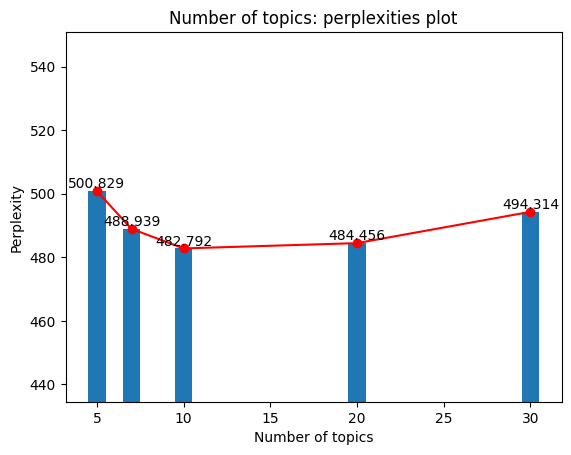

In [9]:
perplexities = eval_lda_n_topics(
    random_state, X_train_cv, n_list=[5, 7, 10, 20, 30], width=1
)

LDA sur les données

In [10]:
n_topics = 10

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=random_state,
)

# topics for train data
lda.fit(X_train_cv)
n_top_words = 10
topics = get_topics(lda, cv_names, n_top_words)

# topics for test data
X_test_lda = lda.transform(X_test_cv)
top_topics_test = [xi.argsort()[:-2:-1][0] for xi in X_test_lda]

# <a id='toc2_'></a>[Score Jaccard](#toc0_)

Création d'un second score, qui correspond à une couverture des tags, mais plus sévère (le tag est exactement présent ou non).  
Ce score est le score Jaccard, une analyse de similarité d'ensembles, représentée ainsi : $$J(A, B) = \frac{|A ∩ B|}{|A ∪ B|}$$

Ce score nécessite une adaptation pour le cas présent puisqu'il prend nécessairement des données de même taille (prédictions et cibles) : pour être cohérent avec le score de couverture de tags précédemment utilisé et sachant que le nombre d'éléments entre cible et prédiction peut différer, il a été convenu d'utiliser en priorité les tags correctement trouvés par le modèle avant d'être complétés par les autres, dans la limite du nombre de tags de la cible.

# <a id='toc3_'></a>[Classification OneVsRest](#toc0_)

#### 🚧 Expliquer [modèle](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/) et [ici dans le cours OC](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855031-allez-plus-loin-dans-la-classification-de-mots#/id/r-4881051)

## <a id='toc3_1_'></a>[Régression logistique](#toc0_)

#### 🚧 Expliquer modèle ([classification](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855026-operez-une-premiere-classification-naive-de-sentiments#/id/r-4880492)) + dire appoche classique (pas de sentence embedding)

In [11]:
%%time
logreg = LogisticRegression(multi_class="ovr")
logreg.fit(X_train_cv, y_train)

/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 2min 28s, sys: 171 ms, total: 2min 28s
Wall time: 2min 28s


LogisticRegression(multi_class='ovr')

In [12]:
lr_preds_raw = logreg.predict(X_test_cv)

Exemple

In [13]:
i = 4

print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"pred:\n\t{lr_preds_raw[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")

data:
	cross-site cookies set cookie backend frontend currently developing webapp frontend backend test jointly chrome frontend make correct api call backend display cookies apology advance long post going many resources past couple day point unsure relevant frontend backend proper settings cors believe backend situation frontend make request backend backend set cookie attempt set cookie backend make request frontend attempt tab chrome get warning network tab get message examining response header research come attempt set cookie backend make request frontend attempt tab chrome get exact warning attempt though response header additionally header warning try come attempt everything attempt except fetch get warning backend missing attempt surely must easy set cookie backend frontend worrying https choice locally backend server accessed research made seem complicated/time-consuming process fair understanding web-dev/all thing network limited
topic 8:
	api request get call spring message br

## <a id='toc3_2_'></a>[Nombre de tags prédits](#toc0_)

Il est possible que certaines prédictions soient nulles ou bien qu'elles ne renvoient pas les 5 tags souhaités

In [14]:
print(f"5 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 5])}")
print(f"4 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 4])}")
print(f"3 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 3])}")
print(f"2 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 2])}")
print(f"1 only tag: {len([p for p in lr_preds_raw if len(p.split(' ')) == 1])}")
print(f"No tag: {len([p for p in lr_preds_raw if len(p.split(' ')) < 1])}")

5 tags: 512
4 tags: 317
3 tags: 111
2 tags: 53
1 only tag: 7
No tag: 0


Il est possible d'utiliser les prédictions pour obtenir directement les 5 tags souhaités

In [15]:
def lr_predict_tags(model, X, n_tags=5) -> list:
    """Use logistic regression probabilities to get at least n predicted tags"""
    ppbs = model.predict_proba(X)
    classes = model.classes_
    pred_tags = []

    for i, x in enumerate(X):
        # create list of tags from n first classes
        pred_list = (
            (" ")
            .join([classes[c] for c in ppbs[i].argsort()[: -n_tags - 1 : -1]])
            .split(" ")
        )
        # keep only 5 first tags
        pred = set()
        j = 0
        while len(pred) < 5:
            pred.add(pred_list[j])
            j += 1
        # add tags to predictions list
        pred_tags.append((" ").join(pred))

    return pred_tags

Application sur les données de test

In [16]:
lr_preds = lr_predict_tags(logreg, X_test_cv)

Exemple

In [17]:
print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"raw predictions:\n\t{lr_preds_raw[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")
print(f"5 tags predictions:\n\t{lr_preds[i]}")

data:
	cross-site cookies set cookie backend frontend currently developing webapp frontend backend test jointly chrome frontend make correct api call backend display cookies apology advance long post going many resources past couple day point unsure relevant frontend backend proper settings cors believe backend situation frontend make request backend backend set cookie attempt set cookie backend make request frontend attempt tab chrome get warning network tab get message examining response header research come attempt set cookie backend make request frontend attempt tab chrome get exact warning attempt though response header additionally header warning try come attempt everything attempt except fetch get warning backend missing attempt surely must easy set cookie backend frontend worrying https choice locally backend server accessed research made seem complicated/time-consuming process fair understanding web-dev/all thing network limited
topic 8:
	api request get call spring message br

Résultats sur l'échantillon de test : prédictions basiques

Tag cover score: 0.227 - Jaccard score: 0.2 - Duration: 14.0


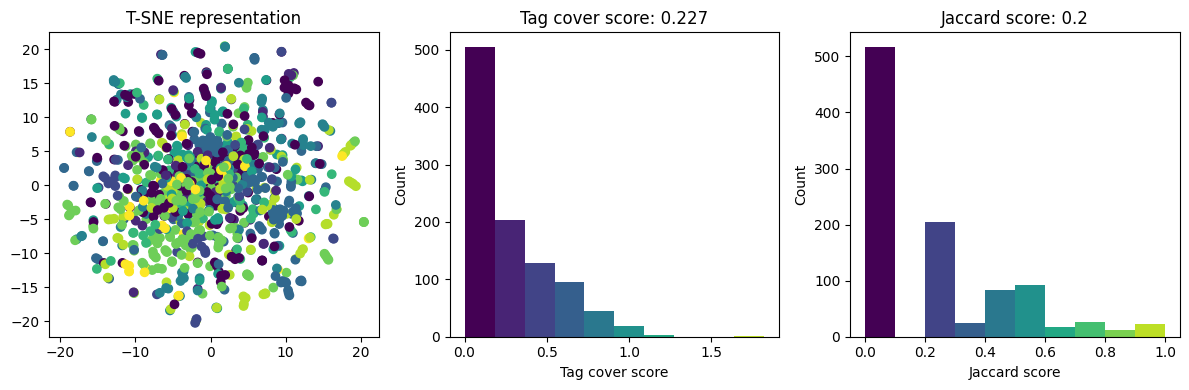

In [18]:
lr_scores_raw = score_plot_model(
    lr_preds_raw, logreg.predict_proba(X_test_cv), y_test, top_topics=top_topics_test
)

Résultats sur l'échantillon de test : prédictions à 5 tags

Tag cover score: 0.258 - Jaccard score: 0.188 - Duration: 14.0


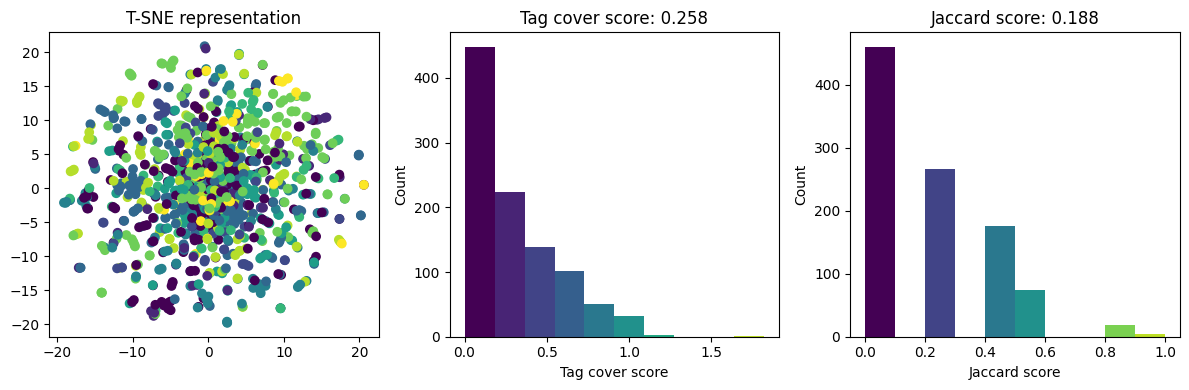

In [19]:
lr_scores = score_plot_model(
    lr_preds, logreg.predict_proba(X_test_cv), y_test, top_topics=top_topics_test
)

Les scores ont mécaniquement évolué avec la prédiction systématique des 5 tags :
- le score de couverture des tags ne peut qu'augmenter avec davantage de prédictions
- le score Jaccard, plus strict et plafonné par le nombre de tags de la cible, est moins impacté

On constate aussi que dans de rares cas, certains scores de couverture de tags sont supérieurs à 1.  
Cela se produit seulement lorsqu'il y a peu de tags et que ceux-ci sont trouvés plusieurs fois par les prédictions.

Comme vu plus haut, le score de Jaccard n'est pas impacté par ce phénomène, ce qui explique partiellement la montée du score de couverture et la stagnation du score de Jaccard.

In [20]:
i = 75

print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"pred:\n\t{lr_preds[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")
print(f"TC score:\n\t{lr_scores[2][i]}")
print(f"J score:\n\t{lr_scores[3][i]}")

data:
	angular this.formgroup.updatevalueandvalidity properly add remove validators controls based certain condition updating validators whole form updating specifically applying control i.e write control hope correct wrong
topic 3:
	test function component class c++ compiler object case call return
pred:
	angular angular-cli angular9 angular8 npm
target:
	angular typescript
TC score:
	1.822
J score:
	0.2


Outre les scores, on constate manuellement que les **prédictions sont souvent cohérentes** avec les données d'entrée.

# <a id='toc4_'></a>[Traitements communs](#toc0_)

## <a id='toc4_1_'></a>[Pré-traitement](#toc0_)

Résumé des traitements précédents, avec tokenisation supplémentaire pour certains modèles prenant en entrée une liste de mots plutôt qu'une chaîne de caractères

In [2]:
# get preprocessed data
df_pp = init_data()

# select from dates and split data
X_train, X_test, y_train, y_test = select_split_data(
    df_pp,
    random_state=42,
    test_size=1000,
    start_date="2019-05-01",
    end_date=None,
)

#  tokenized data
X_train_tok = X_train.str.split(" ")
X_test_tok = X_test.str.split(" ")

print(f"{X_train_tok.shape = }, {X_test_tok.shape = }")

INFO:root:✅ Preprocessed data loaded


X_train_tok.shape = (8999,), X_test_tok.shape = (1000,)


## <a id='toc4_2_'></a>[Évaluation : pipeline](#toc0_)

Création d'un pipeline de pour tester uniformément les modèles, incluant le tracking éventuel des expériences par la bibliothèque MLFlow

In [24]:
def evaluate_model(data, vocab=None, n_topics=5, random_state=42, plot=True, track=False) -> tuple:
    """Train ML model from preprocessed and splitted data, packed in a tuple"""
    start_time = time.time()

    # unpack data
    X_train_vect, X_test_vect, y_train, y_test = data

    # topic modeling for plot output
    if vocab is not None:
        n_top_words = 10
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=5,
            learning_method="online",
            learning_offset=50.0,
            random_state=random_state,
        )
        
        # LDA needs positive values
        X_train_pos = X_train_vect + abs(X_train_vect.min()) if X_train_vect.min() < 0 else X_train_vect
        X_test_pos = X_test_vect + abs(X_test_vect.min()) if X_test_vect.min() < 0 else X_test_vect

        # get topics
        lda.fit(X_train_pos)
        topics = get_topics(lda, vocab, n_top_words)
        X_test_lda = lda.transform(X_test_pos)
        top_topics_test = [xi.argsort()[:-2:-1][0] for xi in X_test_lda]
    else:
        top_topics_test = None

    # classify
    logging.info(f"Classifying...")
    logreg = LogisticRegression(multi_class="ovr")
    logreg.fit(X_train_vect, y_train)
    predicted_probas = logreg.predict_proba(X_test_vect)
    lr_preds = lr_predict_tags(logreg, X_test_vect)
    logging.info(f"✅ {len(lr_preds)} predictions done")

    # score
    logging.info(f"Scoring...")
    score_tc, score_j, scores_tc, scores_j = score_plot_model(
        lr_preds, predicted_probas, y_test, top_topics=top_topics_test, time_it=False
    )

    # duration
    duration = np.round(time.time() - start_time, 0)
    logging.info(f"Total duration: {duration}")

    # 🚧 mlflow : score, métriques, params, modèles, artefacts
    # artefact 1 = PNG plot ?
    # artefact 2 = random sample du DF entraîné avec : input, predict, target, score (10 exemples)

    return score_tc, score_j, duration

## <a id='toc4_3_'></a>[Test avec CountVectorizer](#toc0_)

Vérification que les résultats sont équivalents

In [25]:
%%time

count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=100)

X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)
vocab_cv = count_vectorizer.get_feature_names_out()

CPU times: user 273 ms, sys: 10.1 ms, total: 284 ms
Wall time: 282 ms


INFO:root:Classifying...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
INFO:root:✅ 1000 predictions done
INFO:root:Scoring...


Tag cover score: 0.258 - Jaccard score: 0.188


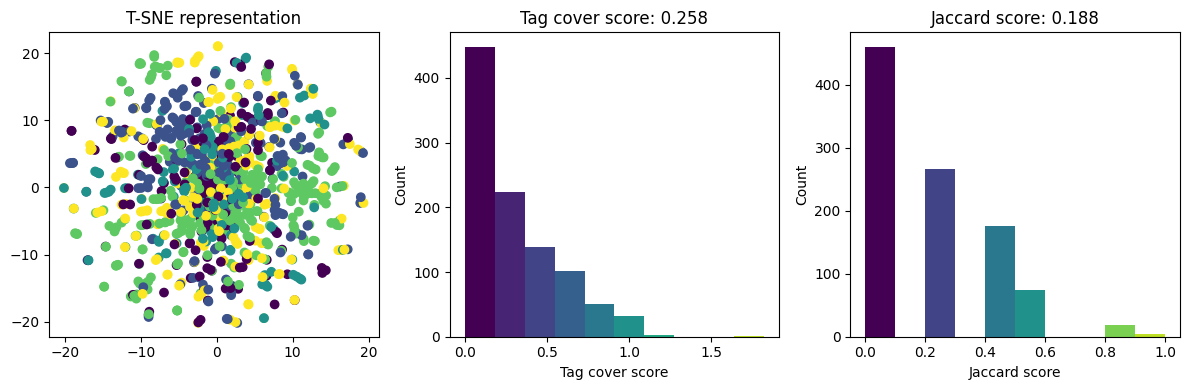

INFO:root:Total duration: 173.0


In [26]:
_ = evaluate_model((X_train_cv, X_test_cv, y_train, y_test), vocab=vocab_cv)

# <a id='toc5_'></a>[Approche *word embedding*](#toc0_)

Le même traitement précédent est appliqué, seulement la vectorisation ne sera plus assurée par une approche bag-of-words comme CountVectorizer mais par des techniques différentes, appelées *word embedding* ou *sentence embedding*.

Ces techniques permettent de créer des vecteurs denses au lieu de grandes matrices vides qui écartent le contexte et le sens et dépendent seulement du corpus fourni.

## <a id='toc5_1_'></a>[Word 2 Vec](#toc0_)

#### 🚧 expliquer modèle : cf. [cours OC](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855006-effectuez-des-plongements-de-mots-word-embeddings) et [❤️ ici](https://openclassrooms.com/fr/courses/6532301-introduction-to-natural-language-processing/8082110-discover-the-power-of-word-embeddings#/id/r-8081925)

In [27]:
%%time

w2v_vectorizer = Word2Vec(
    X_train_tok,        # train set only to avoid data leakage
    min_count=100,      # ignore words that appear less than this
    vector_size=50,     # dimensionality of word embeddings
    sg = 1,             # skipgrams
    window=7,           # context window for words during training
    epochs=10,          # n epochs training over corpus
)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 35474 word types from a corpus of 487937 raw words and 8999 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=100 retains 999 unique words (2.82% of original 35474, drops 34475)', 'datetime': '2024-05-31T13:04:32.389646', 'gensim': '4.3.2', 'python': '3.11.6 (main, Mar 19 2024, 19:27:13) [GCC 11.4.0]', 'platform': 'Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=100 leaves 317658 word corpus (65.10% of original 487937, drops 170279)', 'datetime': '2024-05-31T13:04:32.390829', 'gensim': '4.3.2', 'python': '3.11.6 (main, Mar 19 2024, 19:27:13) [GCC 11.4.0]', 'platform': 'Linux-5.15.146.1-micros

CPU times: user 24.8 s, sys: 97.9 ms, total: 24.9 s
Wall time: 8.63 s


In [28]:
def w2v_vect_data(model, matrix) -> np.array:
    """From a Word2Vec vectorizer, return a vectorized matrix"""
    # loop over rows in tokenized X_train
    doc_vectors = []
    for tokens in matrix:
        # loop over tokens in each row
        doc_vec = []
        for token in tokens:
            if token in model.wv:
                doc_vec.append(model.wv[token])
        # mean it
        doc_vectors.append(np.mean(doc_vec, axis=0))
    # get X_train matrix
    vector_matrix = np.array(doc_vectors)

    return vector_matrix

Vocabulaire

In [29]:
vocab_w2v = np.array(w2v_vectorizer.wv.index_to_key)
print(vocab_w2v.shape)
print(vocab_w2v[:20])

(999,)
['get' 'app' 'one' 'function' 'version' 'project' 'test' 'data' 'https'
 'class' 'time' 'set' 'make' 'type' 'user' 'build' 'api' 'find' 'solution'
 'image']


Vectorisation du set d'entraînement

In [30]:
X_train_w2v = w2v_vect_data(w2v_vectorizer, X_train_tok)
print(X_train_w2v.shape)
print(X_train_w2v[0])

(8999, 50)
[-0.34046116  0.01290528 -0.01315889 -0.06657038 -0.09085577 -0.3228435
 -0.00367685  0.11295792 -0.44330174 -0.03072374  0.11088469  0.2852922
  0.12725675 -0.08908351 -0.15683544 -0.00073691  0.16122031 -0.06207826
  0.11456417 -0.07402651  0.06301153  0.27233222  0.21077222 -0.05112097
  0.05183441  0.2892695  -0.10580353 -0.25229666 -0.18088813  0.07659081
  0.23269206 -0.26454732  0.03818587 -0.04054293  0.21902955  0.15077728
  0.04806168  0.27789742  0.0032239   0.08399588  0.3567217  -0.28566426
 -0.30677533  0.25990146  0.23319066 -0.00269958 -0.14439449 -0.38383242
  0.13339956 -0.21252117]


Vectorisation du set de tests

In [31]:
X_test_w2v = w2v_vect_data(w2v_vectorizer, X_test_tok)
print(X_test_w2v.shape)
print(X_test_w2v[0])

(1000, 50)
[-0.23673435  0.03765076  0.13523304 -0.01613498  0.08647525 -0.55331296
 -0.10944567  0.16775012 -0.39198038 -0.3283487   0.14767267  0.12023111
  0.40444615  0.02895322  0.24644034  0.0506892   0.09257165 -0.29819193
  0.43243948 -0.11030736  0.11973283  0.24865882  0.10923177 -0.5050418
 -0.17222476  0.49543884 -0.15998575  0.15212142 -0.02251265  0.36545777
  0.18817776 -0.2337753  -0.44761077  0.09693257  0.17103006 -0.03804564
  0.12171298  0.26035154  0.21841341  0.23519021  0.12078387 -0.18533157
  0.11796499  0.20369829  0.47691464  0.20306408 -0.22201492 -0.21232653
  0.21924834  0.07608294]


Predictions de tags individuels

In [32]:
# Function to predict tags
def predict_tags_(model, sentence, top_n=5):
    tokenized_sentence = sentence.split(" ")
    valid_tokens = [token for token in tokenized_sentence if token in model.wv]

    if valid_tokens:
        tags = model.wv.most_similar(positive=valid_tokens, topn=top_n)
        return [tag[0] for tag in tags]
    else:
        return []

# EXAMPLE
i = 5344
input_sentence = X_test[i]
target = y_test[i]

w2v_predict_tags = predict_tags_(w2v_vectorizer, input_sentence)
print(f"Sentence\n\t'{input_sentence}")
print(f"Prediction\n\t{w2v_predict_tags}")
print(f"Target\n\t{target}")

Sentence
	'getapplicationdocumentsdirectory flutter desktop windows save open flutter desktop windows getapplicationdocumentsdirectory flutter desktop windows throw
Prediction
	['wsl', 'studio', 'computer', 'mac', 'mobile']
Target
	android windows flutter dart


Évaluation du modèle

INFO:root:Classifying...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
INFO:root:✅ 1000 predictions done
INFO:root:Scoring...


Tag cover score: 0.152 - Jaccard score: 0.121


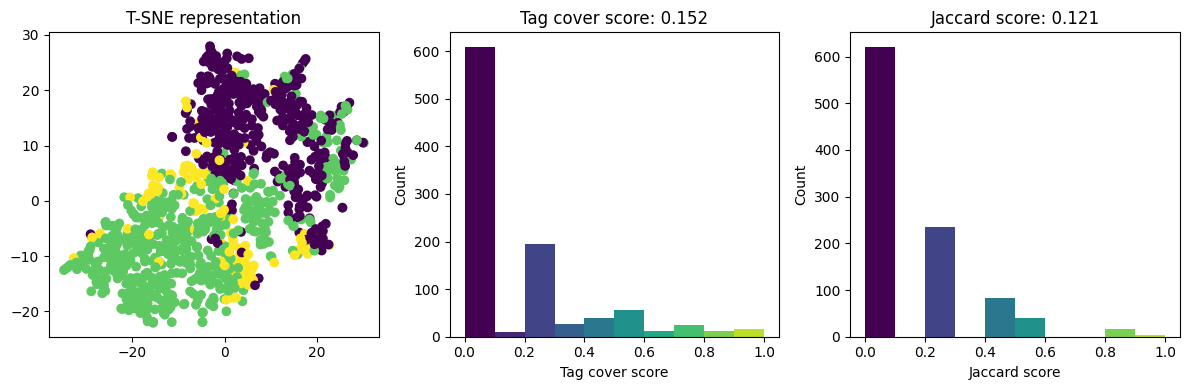

INFO:root:Total duration: 213.0


In [33]:
_ = evaluate_model((X_train_w2v, X_test_w2v, y_train, y_test), vocab=vocab_w2v)

## USE (Universal Sentence Encoder)

#### 🚧 expliquer modèle, cf. [ici](https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder)

In [34]:
%%time

tfuse_vectorizer = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

X_train_tfuse = tfuse_vectorizer(X_train)
X_test_tfuse = tfuse_vectorizer(X_test)

print(X_train_tfuse.shape)
print(X_test_tfuse.shape)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.
2024-05-31 13:08:22.660950: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


(8999, 512)
(1000, 512)
CPU times: user 12.6 s, sys: 4.63 s, total: 17.3 s
Wall time: 13.8 s


### Vocabulaire absent

Avec ce modèle pré-entraîné, il n'est pas possible de :
- l'entraîner à nouveau sur des données personnalisées
- limiter la vectorisation à des mots suffisamment présents
- récupérer le vocabulaire de la vectorisation

Le vocabulaire utilisé n'étant pas accessible (cf. [papier original](https://aclanthology.org/D18-2029/) et [problème soulevé sur GitHub](https://github.com/tensorflow/hub/issues/67)), il n'est pas possible de le passer dans un modèle de topic type LDA (utilisé dans la fonction d'évaluation ci-après).

Évaluation du modèle

INFO:root:Classifying...
/home/jl/projets/OC_P5_SoF/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
INFO:root:✅ 1000 predictions done
INFO:root:Scoring...


Tag cover score: 0.071 - Jaccard score: 0.06


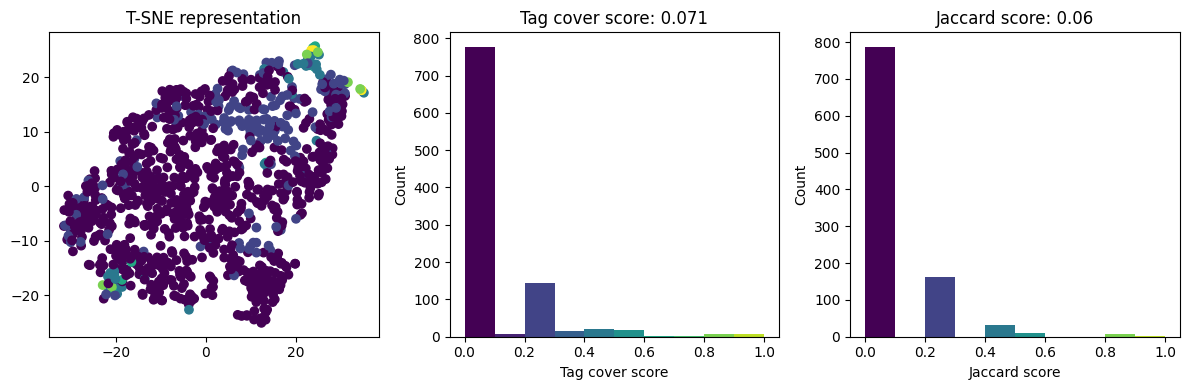

INFO:root:Total duration: 682.0


In [35]:
_ = evaluate_model((X_train_tfuse, X_test_tfuse, y_train, y_test))

# BERT (Bidirectional Encoder Representations from Transformers)

#### 🚧 expliquer modèle, cf. [papier original](https://arxiv.org/abs/1810.04805) et [documentation HF](https://huggingface.co/docs/transformers/main/en/model_doc/bert) et [❤️ classification avec BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=fr)

# <a id='toc6_'></a>[🦄🦄 CHECKPOINT 🦄🦄](#toc0_)

#### 🚧 [NB OC ici](https://github.com/sycod/OC_projects/blob/main/P5/NLP_models_to_see.ipynb)

#### 🚧 choix modèle : dire q pré-entraîné sur 152 million de phrases de Stack Overflow depuis sur une archive de 10 ans

✅ [modèle pré-entraîné SoF lanwuwei](https://huggingface.co/lanwuwei/BERTOverflow_stackoverflow_github) - [papier ici](https://aclanthology.org/2020.acl-main.443/)

❌ [modèle pré-entraîné SoF jeniya](https://huggingface.co/jeniya/BERTOverflow_stackoverflow_github)

❌ [modèle pré-entraîné Stack Exchange AdapterHub](https://huggingface.co/AdapterHub/bert-base-uncased_sts_stackexchange_pfeiffer)

In [63]:
%%time

from transformers import AutoTokenizer
from transformers import TFAutoModelForTokenClassification
from transformers import pipeline

model_name = "lanwuwei/BERTOverflow_stackoverflow_github"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForTokenClassification.from_pretrained(model_name)

loading configuration file config.json from cache at /home/jl/.cache/huggingface/hub/models--lanwuwei--BERTOverflow_stackoverflow_github/snapshots/dfc48d85dd48be7e6458ffd4e939ae71a210caac/config.json
Model config BertConfig {
  "_name_or_path": "lanwuwei/BERTOverflow_stackoverflow_github",
  "_num_labels": 51,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B-Value",
    "1": "B-Algorithm",
    "2": "B-Application",
    "3": "B-Class",
    "4": "B-Code_Block",
    "5": "B-Data_Structure",
    "6": "B-Data_Type",
    "7": "B-Device",
    "8": "B-Error_Name",
    "9": "B-File_Name",
    "10": "B-File_Type",
    "11": "B-Function",
    "12": "B-HTML_XML_Tag",
    "13": "B-Keyboard_IP",
    "14": "B-Language",
    "15": "B-Library",
    "16": "B-Licence",
    "17": "B-Operating_System",
    "18": "B-Organization",
    "19": "B-

CPU times: user 5.86 s, sys: 372 ms, total: 6.23 s
Wall time: 2.94 s


In [67]:
vocab_bert = tokenizer.get_vocab()

In [69]:
len(vocab_bert)

82000

#### 🚧 [doc tuto pipelines HF](https://huggingface.co/docs/transformers/main_classes/pipelines)

In [70]:
token_classifier = pipeline("token-classification", model=model, tokenizer=tokenizer, framework="tf")

In [71]:
X_train_bert = token_classifier(X_train.to_list())

2024-05-31 16:37:25.111328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: indices[0,512] = 512 is not in [0, 512)


InvalidArgumentError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,512] = 512 is not in [0, 512) [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 704), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(1, 704), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

Utilisation des fonctions recommandées dans le cours OC

In [72]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [73]:
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

max_length = 64
batch_size = 10

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, X_train.to_list(), 
    max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /home/jl/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /home/jl/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/mod

1/1 [==============================] - 1s 915ms/step
temps traitement :  1424.0


In [75]:
len(features_bert)

8990

❓ c'est quoi ``last_hidden_states_tot`` ?

In [76]:
len(last_hidden_states_tot)

8990

In [ ]:
# X_train_bert = bert_vectorizer(X_train)
# X_test_ert = bert_vectorizer(X_test)

# print(X_train_bert.shape)
# print(X_test_bert.shape)

🚧 Vocabulaire

Évaluation du modèle

In [37]:
# _ = evaluate_model((X_train_bert, X_test_bert, y_train, y_test), vocab_bert)

# 🚧 qd fonction traitement ok, la passer dans models.py

(mq MLFlow)